**SCM sampler tutorial**

*Author*: J.-G. Young <jean-gabriel.young.1@ulaval.ca> <br/>
*Date*: May 2017.





-----------------

So let's assume that you have managed to compile the source (check the [README](README.md) file otherwise). We will now go over 2 examples of what can be done with the sampler.

First, let's import some required modules: `subprocess` (to call the C++ sampler from `python`), `networkx` and `pyplot`.

In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # for aesthetic
%matplotlib inline
sns.set_style('ticks')

# Rejection sampler

We will begin by sampling from a trivial model: $\mathrm{SCM}(\mathbf{d},\mathbf{s})$ with $\mathbf{d}=(2,2,2,1,1)$ and $\mathbf{s}=(3,3,2)$, which has 12 non-isomorphic instances, shown below:

![](img/simple_instances.png)

The support is not very constrained, meaning that the rejection sampler works well:

In [2]:
with open('/tmp/degrees.txt', 'w') as f:
    print('2 2 1 2 1', file=f)
with open('/tmp/sizes.txt', 'w') as f:
    print('3 3 2', file=f)

In [3]:
command = ['bin/rejection_sampler', '--degree_seq_file=/tmp/degrees.txt', '--size_seq_file=/tmp/sizes.txt', 
           '--seed=0']  # for reproductibility
proc = sp.run(command, stdout=sp.PIPE)
print(proc.stdout.decode())

# Sample:
0 1 4 
0 1 3 
2 3 



In this case, the sampler generated instance # 8 (node identifiers are off by one, since the sampler represents nodes as 0 indexed integers).

To verify that the sampler indeed generates instance uniformly, we will compute the distribution of the length of the cycles in the bipartite graph representation of the simplicial complexes, using `networkx`. It is enough to verify the validity of the sampler, since there are only two possibilities:

![](img/shape.png)

i.e., one cycle of length 4 or one cycle of length 6, represented with equal probability (6 out of 12 instances have a cycle of length 4, the rest have a cycle of length 6).

In [5]:
def facet_list_to_graph(facet_list):
    """Convert a facet list to a bipartite graph"""
    g = nx.Graph()
    for f, facet in enumerate(facet_list):
        for v in facet:
            g.add_edge('v' + str(v), 'f' + str(f))  # differentiate node types
    return g

In [1]:
def rejection_sampling(degree_seq, size_seq, seed=0):
    """Wrapper around the rejection sampler."""
    # Write sequence to files
    with open('/tmp/degrees.txt', 'w') as f:
        print(" ".join([str(x) for x in degree_seq]), file=f)
    with open('/tmp/sizes.txt', 'w') as f:
        print(" ".join([str(x) for x in size_seq]), file=f)
    # Call sampler with subprocess
    command = ['bin/rejection_sampler', '--degree_seq_file=/tmp/degrees.txt', '--size_seq_file=/tmp/sizes.txt', '-d', str(seed)]
    proc = sp.run(command, stdout=sp.PIPE)
    # Read output as a facet list
    facet_list = []
    for line in proc.stdout.decode().split("\n"):
        if line.find("#") == -1 and line != "\n":
            facet_list.append([int(x) for x in line.strip().split()])
    return facet_list[:-1]

In [7]:
num_iter = 200

lengths = []
for i in range(num_iter):
    g = facet_list_to_graph(rejection_sampling([2,2,1,2,1],[3,3,2],i))
    lengths.append(len(nx.cycle_basis(g)[0]))

    
print("Number of cycle of length 4:", len([x for x in lengths if x == 4]))
print("Number of cycle of length 6:", len([x for x in lengths if x == 6]))

Number of cycle of length 4: 96
Number of cycle of length 6: 104


So the sampler is correct (there are of course random fluctuations around the mean!).

# MCMC sampler

The MCMC sampler generates multiples instances (efficiently), so we will first need to construct a function that parses its output.

For the ensemble used above, the output looks like:

In [8]:
command = ['bin/mcmc_sampler', 'datasets/simple_facet_list.txt', '-t', '3', '--seed=42']
proc = sp.run(command, stdout=sp.PIPE)
print(proc.stdout.decode())

# Sample:
0 1 
2 3 4 
1 2 3 
# Sample:
1 2 
0 2 3 
1 3 4 
# Sample:
2 3 
1 3 4 
0 1 2 



The function below calls the sampler and separates the samples in a list:

In [9]:
def rejection_sampling(command, seed=0):
    # Call sampler with subprocess
    proc = sp.run(command, stdout=sp.PIPE)
    # Read output as a facet list 
    facet_list = []
    for line in proc.stdout.decode().split("\n")[1:-1]:
        if line.find("#") == 0:
            yield facet_list
            facet_list = []
        else:
            facet_list.append([int(x) for x in line.strip().split()])
    yield facet_list

In [10]:
# Same command as in cell [8], but parsed:
for x in rejection_sampling(command):
    print(x)

[[0, 1], [2, 3, 4], [1, 2, 3]]
[[1, 2], [0, 2, 3], [1, 3, 4]]
[[2, 3], [1, 3, 4], [0, 1, 2]]


We can now redo the cycle calculation, using the MCMC sampler instead:

In [11]:
command = ['bin/mcmc_sampler', 'datasets/simple_facet_list.txt', '-t', str(num_iter), '--seed=0']

lengths = []
for facet_list in rejection_sampling(command):
    g = facet_list_to_graph(facet_list)
    lengths.append(len(nx.cycle_basis(g)[0]))

    
print("Number of cycle of length 4:", len([x for x in lengths if x == 4]))
print("Number of cycle of length 6:", len([x for x in lengths if x == 6]))

Number of cycle of length 4: 100
Number of cycle of length 6: 100


Again, we have a 50/50 split between both outcomes, as expected. Only this time, the sampler is much faster than the first time around

Let's finish by looking at a more complex dataset, where the MCMC is actually needed: the [crime simplicial complex](datasets/crime_facet_list.txt).

Since there are still few simplicial properties that are easy to compute, we will instead look at a graphical property  in the bipartite graph representation of the pollinator simplicial complex.

The distribution of the degree assortativity coefficient is as good as any.

First, we compute the coefficient of the real dataset

In [12]:
crime_facet_list = []
with open("datasets/crime_facet_list.txt", 'r') as f:
    for l in f:
        crime_facet_list.append([int(x) for x in l.strip().split()])

In [13]:
real = nx.degree_assortativity_coefficient(facet_list_to_graph(crime_facet_list))
print("Real assortativity", real)

Real assortativity -0.267639538869


Let's find what the distribution looks like in the randomized ensemble:

In [16]:
command = ['bin/mcmc_sampler', 'datasets/crime_facet_list.txt', '-t', '500', '--seed=0', '-c', '-b', '500', '-f', '500']
# We cheat by giving somewhat short decorrelation times, this is just so that the example runs fast enough
coeff = []
for facet_list in rejection_sampling(command):
    g = facet_list_to_graph(facet_list)
    coeff.append(nx.degree_assortativity_coefficient(g))


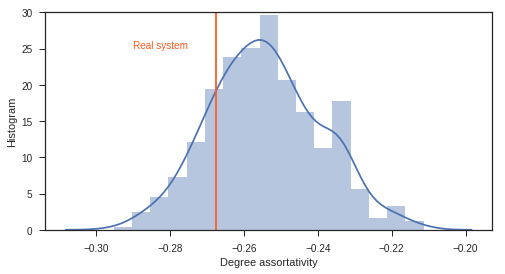

In [17]:
plt.figure(figsize=(8,4))
sns.distplot(coeff, norm_hist=True)
plt.plot([real, real], [0,30], color="#ff5b1e")
plt.text(-0.29,25, 'Real system', color="#ff5b1e")
plt.ylim(0,30)
plt.xlabel('Degree assortativity')
plt.ylabel('Histogram')


The assortativity of the real system therefore seems to be typical. 

**Unrelated note**: The fact that we are looking at a bipartite representation of a simplicial ensemble more or less explain this behavior, so there is nothing worthwhile here.

# Further information: 

"*Construction of and efficient sampling from the simplicial configuration model*"<br/>
[J.-G. Young](http://jgyoung.ca), [G. Petri](https://github.com/lordgrilo), F. Vaccarino, and [A. Patania](https://github.com/alpatania) (2017)<br/>
Phys. Rev. E, **96**, 032312 (2017)

Read it on: [arXiv](https://arxiv.org/abs/1705.10298) | [Phys. Rev. E](https://doi.org/10.1103/PhysRevE.96.032312)
